In [1]:
import datetime
import gc
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import scipy.stats
import seaborn as sns
import sys
sys.path.append("../../")
import time
import warnings
warnings.simplefilter("ignore")
from collections import defaultdict
from itertools import repeat, combinations
from pandarallel import pandarallel
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tqdm import tqdm

In [2]:
from utils.common import (
    sigmoid, pad_column_name
)
from utils.constants import *
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, plot_heatmap,
    get_cols, insert_row_number, plot_train_test_distribution
)
from utils.extraction_helpers import read_file
from utils.feature_group import CATEGORY_COLUMNS

In [3]:
from feature_engineering_helpers import feature_gen_pipeline

In [4]:
%load_ext autoreload
%autoreload

In [5]:
pandarallel.initialize(nb_workers=16, progress_bar=False, use_memory_fs=False)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [6]:
START = time.time()

In [7]:
def combine_binary_features(train, test, final_col_name, col_list, sufficient_count=500, drop_ori=False):
    train["temp"] = train[col_list].astype(str).parallel_apply(lambda x: ''.join(x), axis=1)
    test["temp"] = test[col_list].astype(str).parallel_apply(lambda x: ''.join(x), axis=1)
    le = LabelEncoder()
    le.fit(train["temp"])
    le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
    train_df = train.groupby("temp").agg(
        target_count=("target", "count")
    )
    less_count_cat_codes = train_df.loc[train_df["target_count"] < sufficient_count].index.tolist()
    le_dict = {k: v if k not in less_count_cat_codes else np.nan for k, v in le_dict.items()}
    train[final_col_name] = train["temp"].map(le_dict).astype("category")
    test[final_col_name] = test["temp"].map(le_dict).astype("category")
    if drop_ori:
        train.drop(columns=col_list, inplace=True)
        test.drop(columns=col_list, inplace=True)
    return train, test

### Read Data

In [8]:
labels = read_file(f"../{RAW_DATA_PATH}/train_labels.csv")

Shape of data: (458913, 2)


In [8]:
%%time
train = read_file(f"../{INTERIM_DATA_PATH}/v2/train_parquet/train_all_variables.parquet")
test1 = read_file(f"../{INTERIM_DATA_PATH}/v2/test_parquet/test_all_variables1.parquet")
test2 = read_file(f"../{INTERIM_DATA_PATH}/v2/test_parquet/test_all_variables2.parquet")

Shape of data: (5531451, 199)
Shape of data: (5681079, 198)
Shape of data: (5682683, 198)
CPU times: user 17.3 s, sys: 20.9 s, total: 38.2 s
Wall time: 25.8 s


In [9]:
test = pd.concat([test1, test2], ignore_index=True)
del test1, test2

In [10]:
gc.collect()

18

In [11]:
df_list = [train, test]

In [12]:
for df in df_list:
    df["D_135"] = df["D_135"].fillna(-1)
    df["D_137"] = df["D_137"].fillna(-1)

In [13]:
%%time
n = train.nunique()
binary_features = n[n == 2].index.tolist()

CPU times: user 3.84 s, sys: 741 ms, total: 4.58 s
Wall time: 5.2 s


### Group Features

### Risk Binary

In [14]:
risk_binary_features = [c for c in binary_features if c.startswith("R_")]

In [15]:
sparse_risk_binary_features = train.loc[:, risk_binary_features].sum().sort_values().iloc[:13].index.tolist()
print(sorted(sparse_risk_binary_features))

['R_13', 'R_14', 'R_15', 'R_17', 'R_18', 'R_19', 'R_20', 'R_21', 'R_22', 'R_23', 'R_24', 'R_25', 'R_28']


In [19]:
%%time
train, test = combine_binary_features(
    train, 
    test, 
    final_col_name="R_binaries", 
    col_list=sparse_risk_binary_features, 
    sufficient_count=300, 
    drop_ori=True
)

CPU times: user 1min 7s, sys: 29.3 s, total: 1min 37s
Wall time: 1min 57s


Train-Public PSI: 0.0017, Train-Private PSI: 0.0017


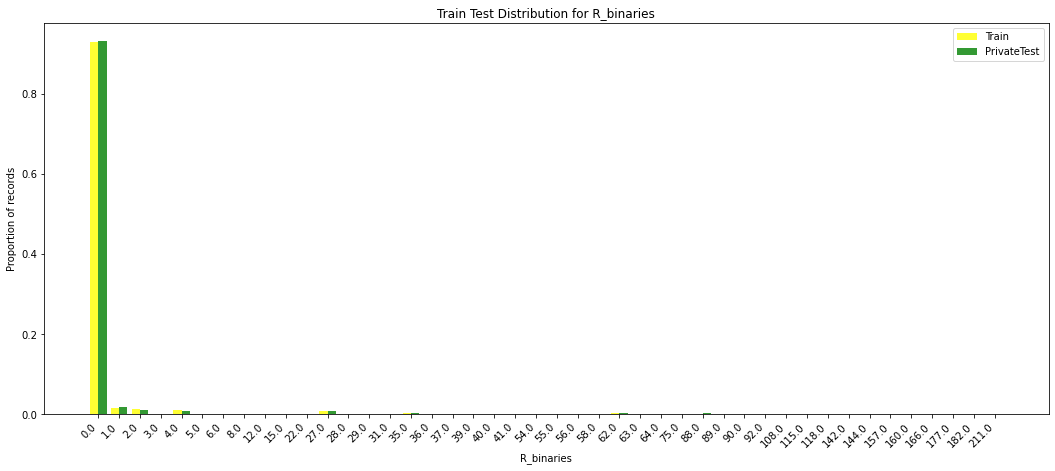

In [42]:
plot_train_test_distribution([train, test], "R_binaries", without_drop_tail=True, is_category=True)

In [22]:
train.shape, test.shape

((5531451, 188), (11363762, 187))

In [23]:
set(train.columns) - set(test.columns)

{'target'}

### Spend Binary

In [27]:
spend_binary_features = [c for c in binary_features if c.startswith("S_")]
print(spend_binary_features)

['S_6', 'S_16', 'S_18', 'S_20']


In [28]:
%%time
train, test = combine_binary_features(
    train, 
    test, 
    final_col_name="S_binaries", 
    col_list=spend_binary_features, 
    sufficient_count=300
)

CPU times: user 20.7 s, sys: 4.02 s, total: 24.7 s
Wall time: 28.2 s


Train-Public PSI: 0.0090, Train-Private PSI: 0.0090


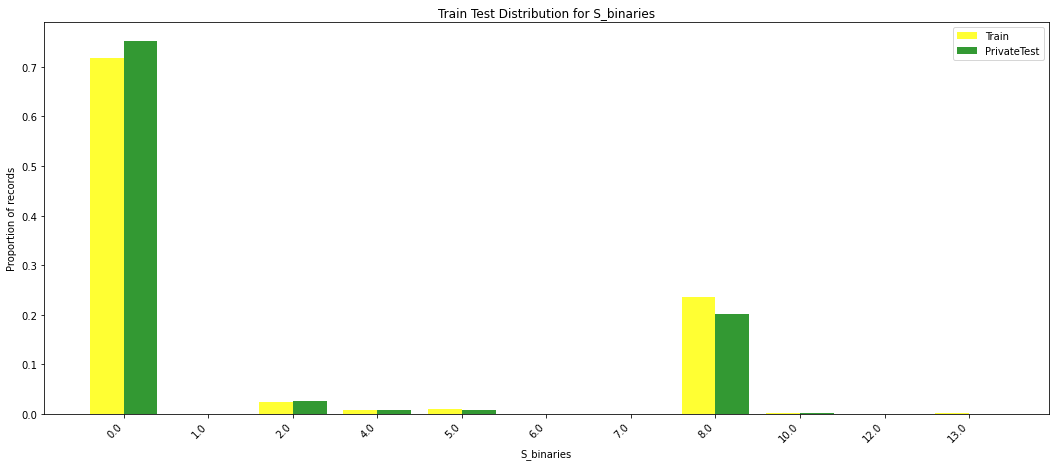

In [41]:
plot_train_test_distribution([train, test], "S_binaries", without_drop_tail=True, is_category=True)

### Balance Binary

In [43]:
balance_binary_features = [c for c in binary_features if c.startswith("B_")]
print(balance_binary_features)

['B_8', 'B_27', 'B_31', 'B_32', 'B_33', 'B_36']


In [44]:
sparse_balance_binary_features = ['B_27', 'B_31', 'B_32']

In [45]:
for col in sparse_balance_binary_features:
    print(train.groupby(col)['target'].mean())

B_27
0    0.248804
1    0.837016
Name: target, dtype: float64
B_31
0    0.720589
1    0.247652
Name: target, dtype: float64
B_32
0    0.242399
1    0.541201
Name: target, dtype: float64


In [46]:
%%time
train, test = combine_binary_features(
    train, 
    test, 
    final_col_name="B_binaries", 
    col_list=balance_binary_features, 
    sufficient_count=500,
    drop_ori=True
)

CPU times: user 33 s, sys: 28.8 s, total: 1min 1s
Wall time: 1min 23s


Train-Public PSI: 0.0158, Train-Private PSI: 0.0158


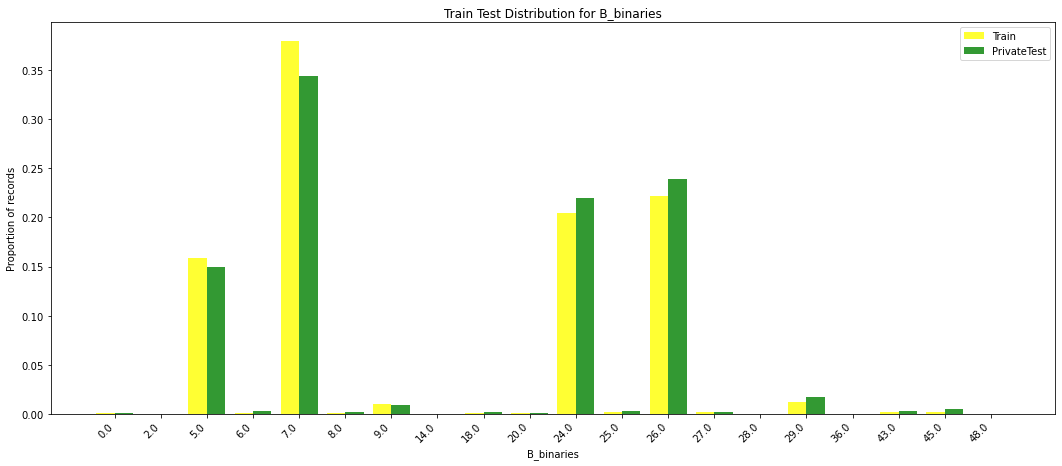

In [47]:
plot_train_test_distribution([train, test], "B_binaries", without_drop_tail=True, is_category=True)

In [48]:
train.shape, test.shape

((5531451, 184), (11363762, 183))

### Delinquency Binaries

In [51]:
delinquency_binary_features = [c for c in binary_features if c.startswith("D_")]
print(delinquency_binary_features)

['D_54', 'D_66', 'D_86', 'D_87', 'D_93', 'D_94', 'D_96', 'D_103', 'D_109', 'D_114', 'D_116', 'D_120', 'D_127', 'D_128', 'D_129', 'D_130', 'D_139', 'D_140', 'D_143']


In [52]:
sparse_delinquency_binary_features = train.loc[:, delinquency_binary_features].sum().sort_values().iloc[:8].index.tolist()
print(sorted(sparse_delinquency_binary_features))

['D_109', 'D_116', 'D_140', 'D_86', 'D_87', 'D_93', 'D_94', 'D_96']


In [ ]:
# for col in sparse_delinquency_binary_features:
#     print(train.groupby(col)['target'].mean())

In [ ]:
# %%time
# train, test = combine_binary_features(
#     train, 
#     test, 
#     final_col_name="D_binaries", 
#     col_list=sparse_delinquency_binary_features, 
#     sufficient_count=500,
#     drop_ori=True
# )

In [ ]:
# plot_train_test_distribution([train, test], "D_binaries", without_drop_tail=True, is_category=True)

In [49]:
train.shape, test.shape

((5531451, 184), (11363762, 183))

In [50]:
train.to_parquet("./merged_train.parquet")
test.to_parquet("./merged_test.parquet")

### Aggregation

#### Train

In [53]:
%%time
train = read_file("./merged_train.parquet")

Shape of data: (5531451, 184)
CPU times: user 5.24 s, sys: 6.58 s, total: 11.8 s
Wall time: 7.41 s


In [54]:
bin_cols = get_cols(train, "_binaries")

In [55]:
train.loc[:, bin_cols] = train.loc[:, bin_cols].astype("category")

In [56]:
%%time
train_agg, keep_column = feature_gen_pipeline(train)

Done insertion
Average done
Minimum done
Maximum done
Standard Deviation done
Skewness done
Last entry done
First entry done
Second last entry done
Third last entry done
MA2 for Recency 1 done
MA2 for Recency 2 done
MA2 for Recency 3 done
MA2 for least Recency done
MA3 for Recency 1 done
MA3 for Recency 2 done


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [01:05<00:00,  2.56it/s]

CPU times: user 4min 6s, sys: 42.1 s, total: 4min 48s
Wall time: 5min 7s


In [57]:
train_agg["target"] = labels["target"].values
print(f"Size: {sys.getsizeof(train_agg) / 1e9} GB, Shape: {train_agg.shape}")

Size: 14.181277593 GB, Shape: (458913, 5068)


In [58]:
float64_columns = train_agg.select_dtypes("float64").columns.tolist()
for col in tqdm(float64_columns):
    temp = train_agg[col].astype(np.float32).values
    if (temp - train_agg[col]).abs().max() < 1e-4:
        train_agg[col] = train_agg[col].astype(np.float32)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2652/2652 [00:33<00:00, 79.68it/s]


In [59]:
print(f"Size: {sys.getsizeof(train_agg) / 1e9} GB, Shape: {train_agg.shape}")

Size: 9.382883265 GB, Shape: (458913, 5068)


In [60]:
number_columns = train_agg.select_dtypes(np.number).columns.tolist()
for col in tqdm(number_columns):
    temp = train_agg[col].round(3)
    if (temp - train_agg[col]).abs().max() < 1e-4:
        train_agg[col] = train_agg[col].round(3)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5012/5012 [00:18<00:00, 276.18it/s]


In [61]:
print(f"Size: {sys.getsizeof(train_agg) / 1e9} GB, Shape: {train_agg.shape}")

Size: 9.382883265 GB, Shape: (458913, 5068)


In [62]:
train_agg = train_agg.loc[:, keep_column]

In [63]:
print(f"Size: {sys.getsizeof(train_agg) / 1e9} GB, Shape: {train_agg.shape}")

Size: 8.760597237 GB, Shape: (458913, 4732)


In [64]:
train_agg.to_pickle(f"./train_agg.pkl")

In [65]:
del train_agg, train

### Test 1

In [66]:
%%time
test = read_file("./merged_test.parquet")

Shape of data: (11363762, 183)
CPU times: user 11.7 s, sys: 18.2 s, total: 29.8 s
Wall time: 25.7 s


In [67]:
bin_cols = get_cols(test, "_binaries")

In [68]:
test1 = test.iloc[:5681884]
test2 = test.iloc[5681884:]

In [69]:
del test
del test2

In [70]:
test1.loc[:, bin_cols] = test1.loc[:, bin_cols].astype("category")

In [71]:
%%time
test_agg, keep_column = feature_gen_pipeline(test1)

Done insertion
Average done
Minimum done
Maximum done
Standard Deviation done
Skewness done
Last entry done
First entry done
Second last entry done
Third last entry done
MA2 for Recency 1 done
MA2 for Recency 2 done
MA2 for Recency 3 done
MA2 for least Recency done
MA3 for Recency 1 done
MA3 for Recency 2 done


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [01:06<00:00,  2.51it/s]

CPU times: user 4min 5s, sys: 44.5 s, total: 4min 50s
Wall time: 5min 9s


In [72]:
print(f"Size: {sys.getsizeof(test_agg) / 1e9} GB, Shape: {test_agg.shape}")

Size: 17.136510259 GB, Shape: (462379, 5067)


In [73]:
float64_columns = test_agg.select_dtypes("float64").columns.tolist()
for col in tqdm(float64_columns):
    temp = test_agg[col].astype(np.float32).values
    if (temp - test_agg[col]).abs().max() < 1e-4:
        test_agg[col] = test_agg[col].astype(np.float32)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4194/4194 [01:18<00:00, 53.32it/s]


In [74]:
print(f"Size: {sys.getsizeof(test_agg) / 1e9} GB, Shape: {test_agg.shape}")

Size: 9.490611115 GB, Shape: (462379, 5067)


In [75]:
test_agg = test_agg.loc[:, keep_column]

In [76]:
print(f"Size: {sys.getsizeof(test_agg) / 1e9} GB, Shape: {test_agg.shape}")

Size: 8.865474707 GB, Shape: (462379, 4732)


In [77]:
test_agg.to_pickle(f"./test_agg1.pkl")

In [78]:
del test_agg

### Test 2

In [79]:
%%time
test = read_file("./merged_test.parquet")

Shape of data: (11363762, 183)
CPU times: user 11.7 s, sys: 18.4 s, total: 30.1 s
Wall time: 26 s


In [80]:
bin_cols = get_cols(test, "_binaries")

In [81]:
test1 = test.iloc[:568184]
test2 = test.iloc[5681884:]

In [82]:
del test
del test1

In [83]:
test = test2.copy()
del test2

In [84]:
test.loc[:, bin_cols] = test.loc[:, bin_cols].astype("category")

In [85]:
%%time
test_agg, keep_column = feature_gen_pipeline(test)

Done insertion
Average done
Minimum done
Maximum done
Standard Deviation done
Skewness done
Last entry done
First entry done
Second last entry done
Third last entry done
MA2 for Recency 1 done
MA2 for Recency 2 done
MA2 for Recency 3 done
MA2 for least Recency done
MA3 for Recency 1 done
MA3 for Recency 2 done


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [01:06<00:00,  2.51it/s]

CPU times: user 4min 5s, sys: 39.5 s, total: 4min 44s
Wall time: 5min


In [86]:
print(f"Size: {sys.getsizeof(test_agg) / 1e9} GB, Shape: {test_agg.shape}")

Size: 17.131437834 GB, Shape: (462242, 5067)


In [87]:
float64_columns = test_agg.select_dtypes("float64").columns.tolist()
for col in tqdm(float64_columns):
    temp = test_agg[col].astype(np.float32).values
    if (temp - test_agg[col]).abs().max() < 1e-4:
        test_agg[col] = test_agg[col].astype(np.float32)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4194/4194 [01:17<00:00, 54.23it/s]


In [88]:
print(f"Size: {sys.getsizeof(test_agg) / 1e9} GB, Shape: {test_agg.shape}")

Size: 9.463767538 GB, Shape: (462242, 5067)


In [89]:
%%time
test_agg = test_agg.loc[:, keep_column]

CPU times: user 1.48 s, sys: 10.5 s, total: 12 s
Wall time: 19.7 s


In [90]:
print(f"Size: {sys.getsizeof(test_agg) / 1e9} GB, Shape: {test_agg.shape}")

Size: 8.84251429 GB, Shape: (462242, 4732)


In [91]:
test_agg.to_pickle(f"./test_agg2.pkl")

In [92]:
del test_agg

### END

In [93]:
END = time.time()

In [94]:
print(f"{END - START:.2f} seconds elapsed")

1451.30 seconds elapsed


### Prepare features for Kaggle training

In [9]:
%%time
train_agg = read_file(f"./train_agg.pkl")

Shape of data: (458913, 4733)
CPU times: user 3.99 s, sys: 10.3 s, total: 14.3 s
Wall time: 20.3 s


In [10]:
train_agg.head()

,customer_ID,D_52_ma3_r1,B_6_skew,D_51_acceleration,B_24_max,B_10_ma2_r3,D_137_sprint,B_16_last_first_ratio,S_8_general_trend,S_8_second_last,...,D_136_previous_sprint,D_60_avg,D_130_sprint,D_102_ma3_r1_r2,D_41_avg,S_3_last_minus_ma2_r2,P_2_ma2_r3,B_37_acceleration,D_138_first,D_110_max
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.200000,1.061827,NaN,0.0,0.320,0.0,NaN,-0.230769,0.75,...,NaN,0.529231,0.0,1.053030,0.0,0.035,0.930,-1.0,NaN,NaN
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.233333,-0.705558,NaN,0.0,0.295,0.0,0.0,-0.134615,0.31,...,NaN,0.321538,0.0,NaN,0.0,0.030,0.890,0.0,NaN,NaN
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.193333,-0.764551,NaN,0.0,0.295,0.0,0.0,NaN,NaN,...,NaN,0.000000,0.0,NaN,0.0,NaN,0.845,NaN,NaN,NaN
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0.190000,-1.555918,NaN,0.0,0.225,0.0,1.0,-0.223077,0.17,...,NaN,0.668462,0.0,NaN,0.0,-0.050,0.610,0.5,NaN,NaN
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0.246667,1.867126,NaN,0.0,0.155,0.0,NaN,-0.007692,0.32,...,NaN,0.000000,0.0,1.097403,0.0,0.000,0.860,NaN,NaN,NaN


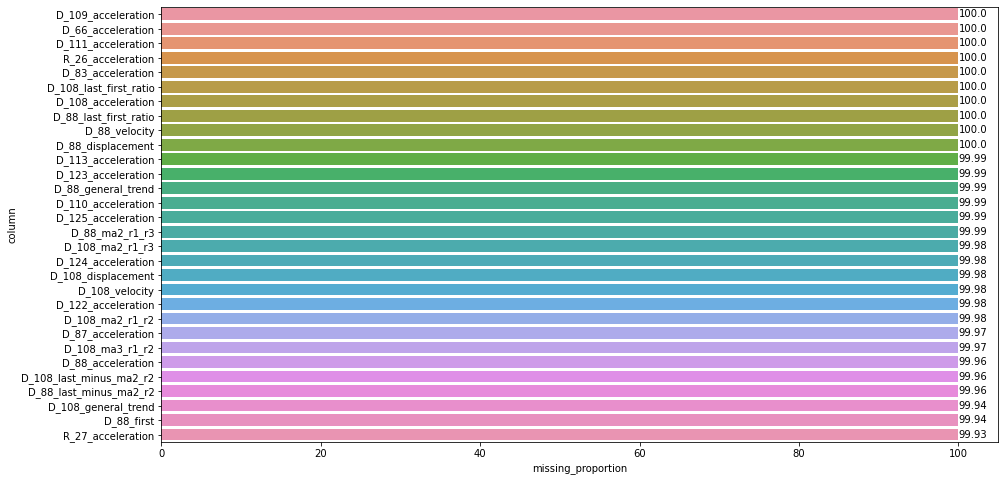

In [11]:
# train_agg = train_agg.loc[:, [c for c in train_agg.columns if c.endswith("_last")]]
# train_agg = train_agg.drop(columns=[c for c in train_agg.columns if c.endswith("_third_last")])
# train_agg = train_agg.drop(columns=[c for c in train_agg.columns if c.endswith("_second_last")])
m = plot_missing_proportion_barchart(train_agg)

In [13]:
high_missing_columns = m.loc[m["missing_proportion"] > 99]["column"].tolist()
len(high_missing_columns)

187

In [14]:
%%time
train_agg = train_agg.drop(columns=high_missing_columns, errors="ignore")

CPU times: user 661 ms, sys: 1.74 s, total: 2.4 s
Wall time: 3.96 s


In [15]:
train_agg.shape

(458913, 4546)

In [16]:
def select_bad_features(feature_imp_df, threshold):
    bad_features = []
    feature_imp_df = feature_imp_df.fillna(0)
    for type_ in feature_imp_df.columns[1:]:
        bad_features.extend(
            (
                feature_imp_df.loc[feature_imp_df[type_] < threshold]["base_feature"] + "_" + type_
            ).tolist()
        )
    # print(len(good_features), feature_imp_df.shape[0] * (feature_imp_df.shape[1] - 1))
    return bad_features

In [17]:
def select_good_features(feature_imp_df, threshold):
    good_features = []
    for type_ in feature_imp_df.columns[1:]:
        good_features.extend(
            (
                feature_imp_df.loc[feature_imp_df[type_] >= threshold]["base_feature"] + "_" + type_
            ).tolist()
        )
    # print(len(good_features), feature_imp_df.shape[0] * (feature_imp_df.shape[1] - 1))
    return good_features

In [18]:
summary_feature_imp3 = read_file(f"../{EXP_PATH}/3.lgbm_dart_5197/feature_importance.csv")
summary_feature_imp5 = read_file(f"../{EXP_PATH}/5.lgbm_dart_923_half_fix/feature_importance.csv")

Shape of data: (166, 24)
Shape of data: (181, 39)


In [19]:
median_fi3 = summary_feature_imp3.median().median()
median_fi5 = summary_feature_imp5.median().median()
median_fi3, median_fi5

(130.2, 106.5)

In [22]:
bad_features = list(
    set(select_bad_features(summary_feature_imp3, median_fi3))
    .intersection(select_bad_features(summary_feature_imp5, median_fi5))
    .intersection(train_agg.columns)
)
len(bad_features)

1633

In [23]:
train_agg.shape

(458913, 4546)

In [24]:
%%time
train_agg = train_agg.drop(columns=bad_features)

CPU times: user 331 ms, sys: 2.47 s, total: 2.8 s
Wall time: 4.73 s


In [25]:
train_agg.select_dtypes("category").columns

Index(['D_116_last', 'D_63_third_last', 'D_92_second_last', 'D_64_third_last',
       'D_116_second_last', 'R_binaries_third_last', 'D_117_third_last',
       'S_binaries_first', 'D_64_second_last', 'S_binaries_second_last',
       'R_binaries_last', 'D_68_third_last', 'R_binaries_second_last',
       'B_38_first', 'D_92_first', 'S_binaries_last', 'D_64_last',
       'D_116_third_last', 'B_binaries_last', 'D_117_last', 'D_114_last',
       'D_92_last', 'D_68_last', 'B_38_second_last', 'D_68_first',
       'D_117_second_last', 'D_114_second_last', 'B_binaries_first',
       'D_92_third_last', 'D_120_third_last', 'B_binaries_second_last',
       'D_68_second_last', 'B_38_last', 'R_binaries_first', 'D_120_last',
       'D_117_first', 'B_binaries_third_last', 'D_116_first',
       'B_38_third_last', 'D_126_third_last', 'B_30_third_last',
       'D_114_third_last', 'S_binaries_third_last'],
      dtype='object')

In [26]:
train_agg.shape

(458913, 2913)

In [27]:
train_agg.to_parquet(f"./final_train_agg.parquet")